A UNET-style neural network trained on the KITTI dataset to distinguish road pixels from all others

# Import and Explore Data

In [109]:
import tensorflow as tf
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob

%matplotlib inline
import matplotlib.pyplot as plt

I had the data_road.zip from KITTI on my computer already so I scp'ed it to the instance.

In [72]:
# # Unzip KITTI data
# zip_path = 'data_road.zip'
# zip_ref = zipfile.ZipFile(zip_path, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [110]:
train_dir = 'data_road/training'
test_dir = 'data_road/testing'
train_imgs_path = os.path.join(train_dir, 'image_2')
train_gt_path = os.path.join(train_dir, 'gt_image_2')
test_imgs_path = os.path.join(test_dir, 'image_2')
imgs = glob.glob(os.path.join(train_imgs_path, "*.png"))
gt = glob.glob(os.path.join(train_gt_path, "*road*.png"))
test_imgs = glob.glob(os.path.join(test_imgs_path, "*.png"))
imgs.sort()
gt.sort()

In [111]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

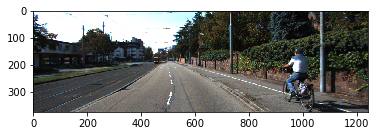

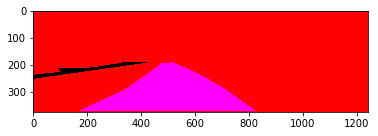

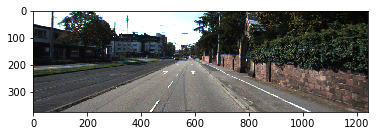

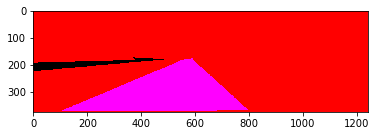

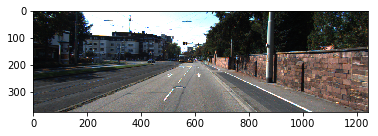

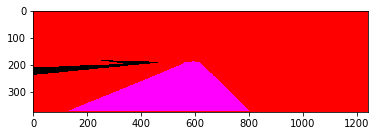

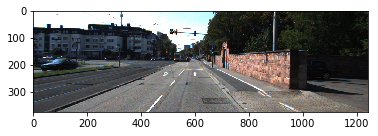

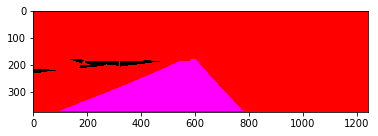

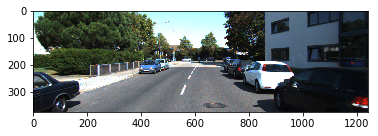

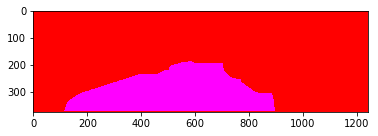

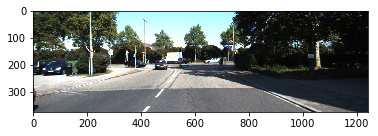

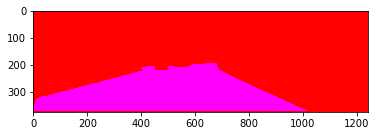

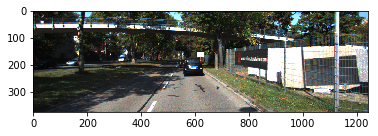

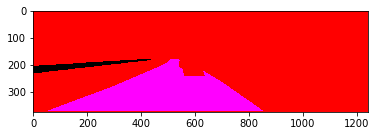

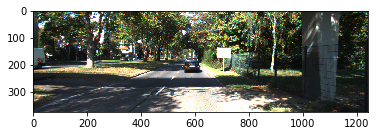

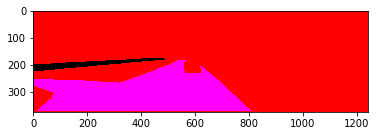

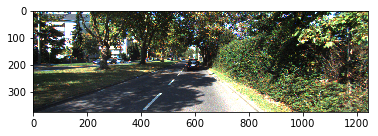

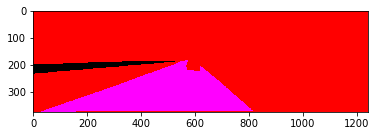

In [112]:
# Let's look at some sample images and their ground truths
for i in range(9):
    plot_image(imgs[i])
    plot_image(gt[i])

In [113]:
img_array = np.asarray(misc.imread(gt[0]))
# This will be the background color
print(img_array[0,0])
# This will be the road color
print(img_array[320,600])

[255   0   0]
[255   0 255]


So the pink is our roadway, the red is everything else and the black will be ignored for my purposes.

# Utility Functions

In [114]:
def prepare_ground_truth(img):
    # This will make it a two-channel binary image for two classes
    new_image = np.zeros((img.shape[0], img.shape[1], 2))
    blue_image = img[:,:,2]
    green_image = img[:,:,1]
    # Get the road marks by including only pixels that have blue
    # but don't have green (this will include the pink road but not
    # the red background or black)
    new_image[(blue_image > 0) * (green_image == 0), 1] = 1
    new_image[:, :, 0] = np.logical_not(new_image[:, :, 1]).astype(float)
    
    return new_image

In [115]:
# Get frequency figures for free space pixels vs. background pixels
# to properly weight cost function
# More info here: https://blog.fineighbor.com/tensorflow-dealing-with-imbalanced-data-eb0108b10701

total_road_pixs = 0
total_back_pixs = 0

# After looking through the data I noticed that some of the pictures are 370/Y and some are 375/Y
# so I'm standardizing them at the smaller size
row_size = 370
col_size = 1226

for i, label in enumerate(gt):
    im = misc.imread(label)
    if (im.shape[0] != row_size):
        im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
    im = prepare_ground_truth(im)
    size= im.shape[0]*im.shape[1]
    total_road_pixs += np.sum(im[:,:,1]) / size
    total_back_pixs += np.sum(im[:,:,0]) / size
    if (i % 100 == 0):
        print (i, " images calculated")

road_freq = total_road_pixs / len(gt)
back_freq = total_back_pixs / len(gt)

print("road freq is", road_freq)
print("back freq is", back_freq)

0  images calculated
100  images calculated
200  images calculated
road freq is 0.180677735995
back freq is 0.819322264005


In [116]:
# I noticed that it's having trouble dealing with shadows so this should
# help it become less reliant on color alone
def augment_image(image, augment_prob=0.75, max_delta=0.5):
    # decide whether to augment at all
    if (uniform(0, 1.0) > augment_prob):
        return image
    # add brightness/shadow
    add_brightness = uniform(-max_delta, max_delta)
    image += add_brightness
    im_range = np.abs(add_brightness) + 1.0
    image /= im_range
    return image

In [117]:
def get_train_batches(batch_size=1, augment=True, num_classes=2, mode='train', data_dir=train_imgs_path, labels_dir=train_gt_path):
    
    # Save last 40 images/labels for validation
    validation_size = 20
    
    imgs = glob.glob(os.path.join(data_dir, "*.png"))
    gt = glob.glob(os.path.join(labels_dir, "*road*.png"))
    
    imgs.sort()
    gt.sort()
    
    # Shuffle dataset
    combined = list(zip(imgs, gt))
    shuffle(combined)
    imgs[:], gt[:] = zip(*combined)
    
    if (mode == 'train'):
        imgs = imgs[:-validation_size]
        gt = gt[:-validation_size]
    elif (mode == 'validate'):
        imgs = imgs[-validation_size:]
        gt = gt[-validation_size:]
    else:
        raise ValueError("Unrecognized mode")
    
    # Import one image to check the size
    size_img = misc.imread(imgs[0])
    images = np.empty([len(imgs), row_size, col_size, size_img.shape[2]])
    labels = np.empty([len(gt), row_size, col_size, num_classes])
    
    # Handle pre-processing here
    for i, img in enumerate(imgs):
        im = misc.imread(img)
        if (im.shape[0] != row_size):
            im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
        im = (im - 117.0) / 117.0
        
        if (mode=='train' and augment==True):
            im = augment_image(im)
        
        images[i,:,:,:] = im

    for i, label in enumerate(gt):
        im = misc.imread(label)
        if (im.shape[0] != row_size):
            im = im[im.shape[0]-row_size:,im.shape[1]-col_size:,:]
        labels[i,:,:,:] = prepare_ground_truth(im)
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            yield(images[i:i+batch_size,:,:,:],labels[i:i+batch_size,:,:,:])

In [118]:
# Because we lose a little of the border doing 'VALID' convolutions,
# we'll need to crop the output of our earlier layers to match the later
# outputs we'll combine them with
def crop_images(input_im, shape):
    
    row_offset = (input_im.shape[1] - shape[1]) // 2
    col_offset = (input_im.shape[2] - shape[2]) // 2
    input_im = input_im[:, row_offset:(-row_offset), col_offset:(-col_offset), :]
    return input_im

In [119]:
def post_process(im):
    im *= 117
    im += 117
    im = im.astype(np.uint8)
    return im

In [144]:
# After we have our prediction, we need a way to see it on the image
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    new_image = np.copy(original_image)
    new_image[mask[:,:] > 0, :] = [0, 255, 0]
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

# Build Model

In [121]:
def create_UNET(imgs, dropout=0.5, num_layers=4, channels=3, num_classes=2, initial_features=16, filter_size=3, pool_size=2):
    
    im_rows = tf.shape(imgs)[1]
    im_cols = tf.shape(imgs)[2]
    
    x_image = tf.reshape(imgs, tf.stack([-1,im_rows,im_cols,channels]))
    layer_input = x_image
    batch_size = tf.shape(x_image)[0]
    
    store_layers = OrderedDict()
    
    # Encoder
    for layer in range(num_layers):
        
        # CNN features should double each layer as we encode
        features = (2**layer)*initial_features
        # Given in the paper
        stddev = np.sqrt(2 / ((filter_size**2)*features))
        
        if layer == 0:
            w1 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, channels, features], stddev=stddev), name=("w1_d_" + str(layer)))
        else:
            w1 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, features//2, features], stddev=stddev), name=("w1_d_" + str(layer)))
        
        b1 = tf.Variable(tf.constant(0.1, shape=[features]))
        w2 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, features, features], stddev=stddev), name=("w2_d_" + str(layer)))
        b2 = tf.Variable(tf.constant(0.1, shape=[features]))
        
        # Add dropout here later
        conv1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.nn.conv2d(layer_input, w1, strides=[1, 1, 1, 1], padding='VALID'), b1)), dropout)
        conv2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.nn.conv2d(conv1, w2, strides=[1, 1, 1, 1], padding='VALID'), b2)), dropout)
        
        store_layers[layer] = conv2
        
        if layer < num_layers - 1:
            layer_input = tf.nn.max_pool(conv2, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_size, pool_size, 1], padding='VALID')
        else:
            layer_input = conv2
            
    # Helper function for deconvolutional layers
    def deconv2d(x, W, stride):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID')
    
    # Helper function for the resnet-like recombinations
    # of previous layers with new ones, upscaled to the same size
    # (This is where a lot of the magic of UNET is happening)
    def crop_and_concat(x1,x2):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)
    
    # Decoder
    # cycle through the layers backwards starting with the second
    # to last
    for layer in range(num_layers - 2, -1, -1):
        
        features = (2**(layer+1))*initial_features
        stddev = np.sqrt(2 / ((filter_size**2) * features))
        
        d_w = tf.Variable(tf.truncated_normal(shape=[pool_size, pool_size, features//2, features], stddev=stddev), name=("down_w"))
        d_b = b1 = tf.Variable(tf.constant(0.1, shape=[features//2]))
        d_layer = tf.nn.relu(tf.add(deconv2d(layer_input, d_w, pool_size), d_b))
        d_out = crop_and_concat(store_layers[layer], d_layer)
        
        w1 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, features, features//2], stddev=stddev), name=("w1_u_" + str(layer)))
        b1 = tf.Variable(tf.constant(0.1, shape=[features//2]))
        w2 = tf.Variable(tf.truncated_normal(shape=[filter_size, filter_size, features//2, features//2], stddev=stddev), name=("w2_u_" + str(layer)))
        b2 = tf.Variable(tf.constant(0.1, shape=[features//2]))
        
        conv1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.nn.conv2d(d_out, w1, strides=[1, 1, 1, 1], padding='VALID'), b1)), dropout)
        conv2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.nn.conv2d(conv1, w2, strides=[1, 1, 1, 1], padding='VALID'), b2)), dropout)
        
        layer_input = conv2
    
    # Prepare output
    final_w = tf.Variable(tf.truncated_normal(shape=[1, 1, initial_features, num_classes], stddev=stddev), name="final_w")
    final_b = tf.Variable(tf.constant(0.1, shape=[num_classes]))
    final_conv = tf.nn.relu(tf.add(tf.nn.conv2d(layer_input, final_w, strides=[1, 1, 1, 1], padding='VALID'), final_b))
    
    output = final_conv
    
    all_vars = tf.trainable_variables()
    
    # Return variables as well for regularization
    return output, all_vars

In [168]:
class UNET:
    
    def __init__(self, channels=3, num_classes=2, num_layers=4):
        
        # prediction path is to store validation prediction images in when necessary
        self.prediction_path = "predictions"
        self.output_path = "model"
        
        if not os.path.exists(self.prediction_path):
            os.mkdir(self.prediction_path)
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
                
        tf.reset_default_graph()
        
        self.num_classes = num_classes
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels])
        self.y = tf.placeholder("float", shape=[None, None, None, num_classes])
        self.drop_pl = tf.placeholder("float")

        logits, self.vars = create_UNET(self.x, dropout=self.drop_pl, channels=channels, num_classes=num_classes, num_layers=num_layers)
        
        self.loss = self.get_loss(logits)
        
        self.predictor = self.pixel_wise_softmax(logits)
        
        # These two are for validation
        self.correct_pred = tf.equal(tf.argmax(self.predictor, 3), tf.argmax(self.y, 3))
        
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
    
    # A helper function for computing softmax across the channel-dimension as is necessary
    # with UNET
    def pixel_wise_softmax(self, output):
                
        # Softmax across the last dimension (where each channel is a binary image
        # denoting whether the pixel belongs in that category or not -- this allows
        # for more than two classes)
        # e^x
        exponential_map = tf.exp(output)
        # sum-e^x
        sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
        # duplicate the last summed dimension
        tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output)[3]]))
        # divide e^x by sum-e^x 
        return tf.div(exponential_map, tensor_sum_exp)
        
    def get_loss(self, logits, loss_beta=.01):
                
        flat_logits = tf.reshape(logits, [-1, self.num_classes])
        flat_labels = tf.reshape(self.y, [-1, self.num_classes])
        
        # Make sure you're not dividing by zero
        eps = tf.constant(value=1e-10)
        flat_logits = flat_logits + eps
        
        softmax = tf.nn.softmax(flat_logits)
        
        # Weight the classes by their relative frequencies so the gradients
        # for less frequent classes don't vanish
        coeffs = tf.constant([(0.5/back_freq), (0.5/road_freq)])
        
        cross_entropy = -tf.reduce_sum(tf.multiply(flat_labels * tf.log(softmax + eps), coeffs), reduction_indices=[1])
        
        # Add regularization loss as well
        loss_L2 = tf.add_n([ tf.nn.l2_loss(v) for v in self.vars
                    if 'w' in v.name ]) * loss_beta
        
        cost = tf.reduce_mean(tf.add(cross_entropy, loss_L2), name='cost')
        
        return cost
    
    def get_shape(self, img):
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            prediction = sess.run(self.predictor, feed_dict={self.x: img, self.drop_pl: 1.0})

        return prediction.shape
    
    def predict(self, model_path, img, size=None, gt=None, restore=True):
    
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            if restore:
                self.restore(sess, model_path)
            
            if (gt != None):
                gt = crop_images(gt, size)
            
            prediction, acc = sess.run([self.predictor, self.accuracy], feed_dict={self.x: img, self.y: gt, self.drop_pl: 1.0})

        return prediction, acc
    
    def save(self, sess, model_path):
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def train(self, data_generator, output_path, dropout=0.5, training_iters=10, learning_rate=0.0001, epochs=10, display_step=100, restore=False, model_path=None):
        
        model_path = os.path.join(self.output_path, "unet.ckpt")
                
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Session begun")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)
            
            # Run single test image to get size right, return test_shape
            test_batch, test_gt = next(data_generator)
            test_result = sess.run(self.predictor, feed_dict={self.x: test_batch,
                                                             self.drop_pl: 1.0})
            output_shape = test_result.shape
            
            for epoch in range(epochs):
                
                print("Starting new epoch")
                
                total_loss = 0
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    x_batch, y_batch = next(data_generator)
                                        
                    # Crop y_batch to match the test_shape
                    y_batch = crop_images(y_batch, output_shape)
                    
                    _, loss, _ = sess.run((self.optimizer, self.loss, self.vars),
                                                    feed_dict={self.x: x_batch,
                                                              self.y: y_batch,
                                                              self.drop_pl: dropout})
                    
                    total_loss += loss
                    
                    if (step % display_step == 0):
                        print("current loss =", loss)
                                            
                print("###############################")
                print("Epoch", epoch, "average loss =", total_loss/training_iters)
                print("###############################")
                total_loss = 0                
                
            save_path = self.save(sess, model_path)
        
        return save_path

# Train Model

In [169]:
tf.reset_default_graph()

In [170]:
my_unet = UNET(num_layers=4)

In [171]:
batch_generator = get_train_batches()
output_path = 'model'
model_path = 'unet_adv.ckpt'

In [1]:
model_path = my_unet.train(batch_generator, output_path, learning_rate=0.0008, training_iters=269, epochs=40, restore=True, model_path=model_path)


# Test Model

In [173]:
tf.reset_default_graph()

In [174]:
my_unet = UNET(num_layers=4)

In [175]:
batch_generator = get_train_batches(mode='validate')

In [176]:
test_img, test_gt = next(batch_generator)

In [156]:
output_shape = my_unet.get_shape(test_img)

In [177]:
import time
time1 = time.time()
supposed_pred, acc = my_unet.predict(model_path, test_img, size=output_shape, gt=test_gt, restore=True)
time2 = time.time()
print ("It took ", (time2-time1)*1000, " miliseconds")

INFO:tensorflow:Restoring parameters from model/unet.ckpt
It took  292.3016548156738  miliseconds


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Accuracy = 0.901815


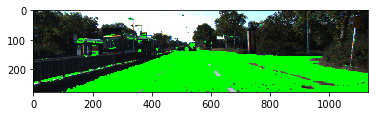

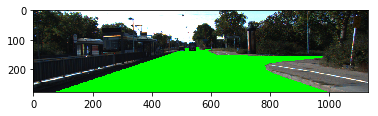

In [178]:
print("Accuracy =", acc)

output_shape = supposed_pred.shape

# Preprocess
cut_test_img = crop_images(test_img, output_shape)
cut_test_gt = crop_images(test_gt, output_shape)
cut_test_img = post_process(cut_test_img)
# Make the combination image
visualize_prediction(cut_test_img, supposed_pred)
visualize_prediction(cut_test_img, cut_test_gt)

# Evaluate Model

In [179]:
tf.reset_default_graph()

In [180]:
my_unet = UNET(num_layers=4)

In [181]:
batch_generator = get_train_batches(mode='validate')

INFO:tensorflow:Restoring parameters from model/unet.ckpt


/home/ubuntu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


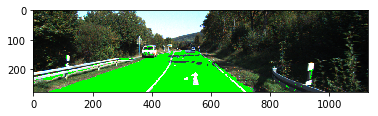

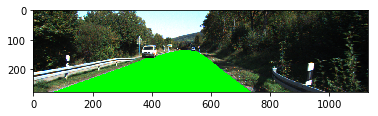

INFO:tensorflow:Restoring parameters from model/unet.ckpt


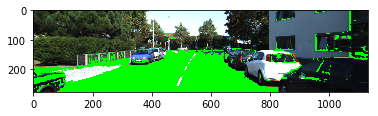

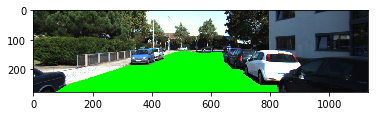

INFO:tensorflow:Restoring parameters from model/unet.ckpt


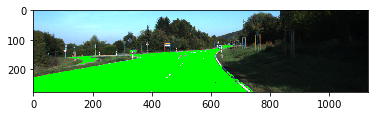

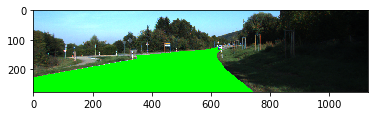

INFO:tensorflow:Restoring parameters from model/unet.ckpt


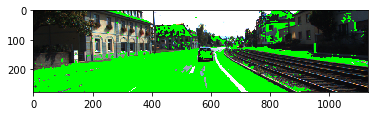

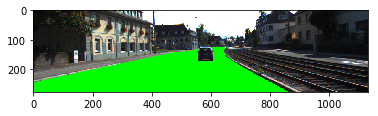

INFO:tensorflow:Restoring parameters from model/unet.ckpt


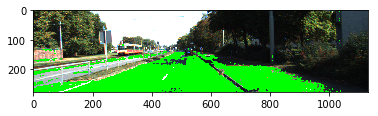

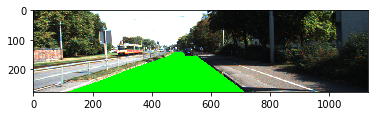

INFO:tensorflow:Restoring parameters from model/unet.ckpt


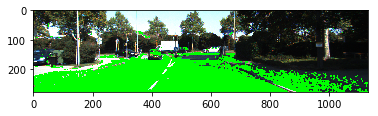

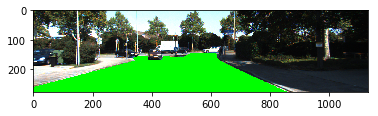

INFO:tensorflow:Restoring parameters from model/unet.ckpt


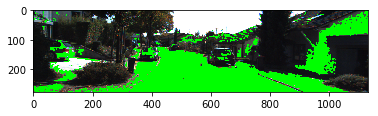

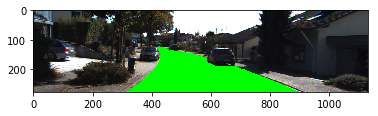

INFO:tensorflow:Restoring parameters from model/unet.ckpt


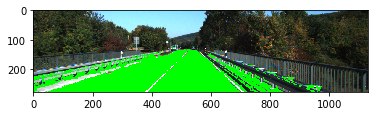

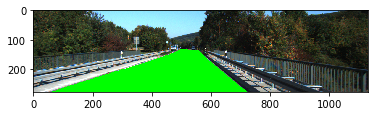

INFO:tensorflow:Restoring parameters from model/unet.ckpt


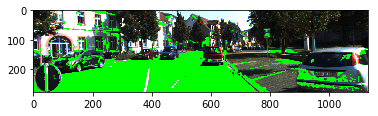

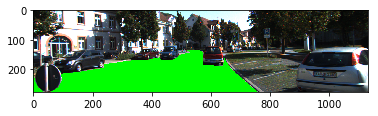

INFO:tensorflow:Restoring parameters from model/unet.ckpt


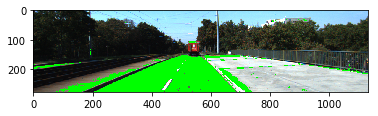

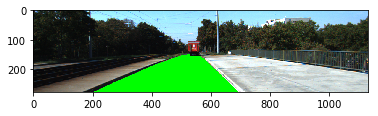

INFO:tensorflow:Restoring parameters from model/unet.ckpt


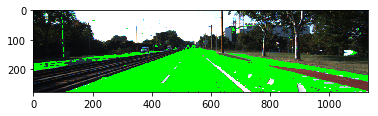

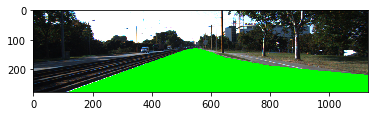

INFO:tensorflow:Restoring parameters from model/unet.ckpt


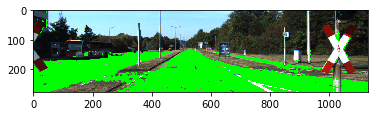

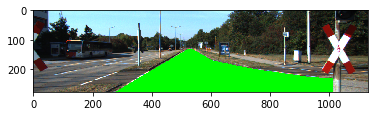

INFO:tensorflow:Restoring parameters from model/unet.ckpt


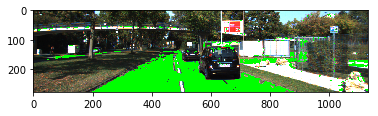

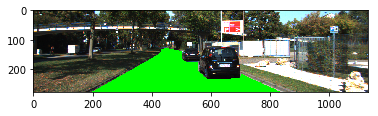

INFO:tensorflow:Restoring parameters from model/unet.ckpt


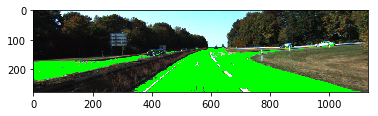

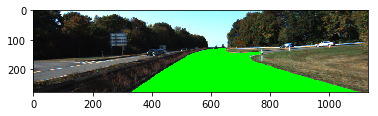

INFO:tensorflow:Restoring parameters from model/unet.ckpt


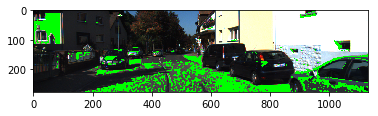

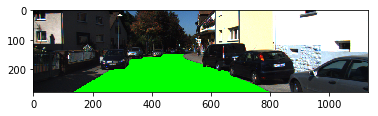

INFO:tensorflow:Restoring parameters from model/unet.ckpt


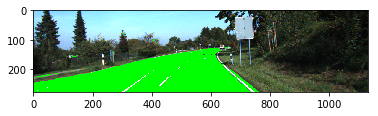

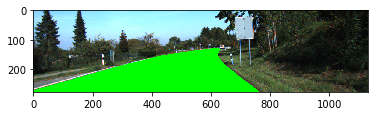

INFO:tensorflow:Restoring parameters from model/unet.ckpt


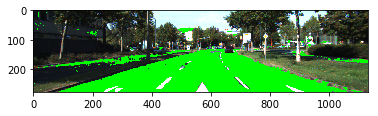

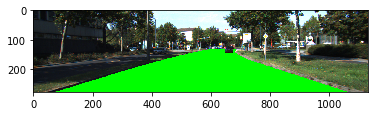

INFO:tensorflow:Restoring parameters from model/unet.ckpt


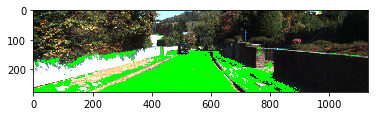

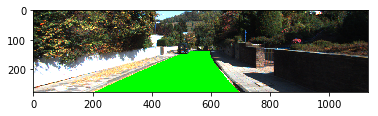

INFO:tensorflow:Restoring parameters from model/unet.ckpt


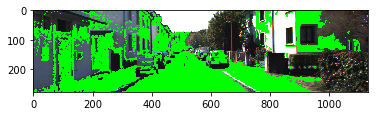

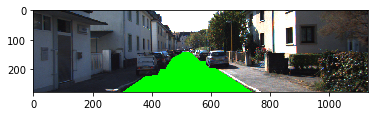

INFO:tensorflow:Restoring parameters from model/unet.ckpt


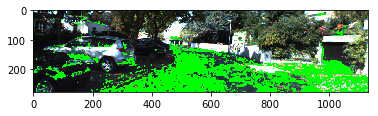

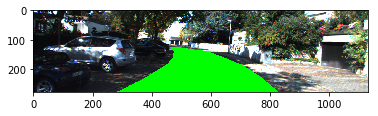

###############################
Average validation set accuracy = 0.908050307631
###############################


In [182]:
total_acc = 0.0
val_size = 20

for i in range(val_size):
    val_img, val_gt = next(batch_generator)
    results, acc = my_unet.predict(model_path, val_img, size=output_shape, gt=val_gt, restore=True)
    total_acc += acc
    
    # Preprocess
    cut_val_img = crop_images(val_img, output_shape)
    cut_val_gt = crop_images(val_gt, output_shape)
    cut_val_img = post_process(cut_val_img)
    # Make the combination image
    visualize_prediction(cut_val_img, results)
    visualize_prediction(cut_val_img, cut_val_gt)

total_acc /= val_size
print("###############################")
print("Average validation set accuracy =", total_acc)
print("###############################")